# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) 
# Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.


# Job scrapping

1. Job are scraped from mycareerfutures.sg
2. Job searched with keyword data
3. The job scrapping code can be found in the folder datajob
4. Totally 4000+ jobs are scrapted
5. To match the scope of the project, kept 1000+ jobs that can be determined as data related job from their job title


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, HuberRegressor, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from textblob import TextBlob
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
sns.set_style('white')

In [2]:
# load the job scraped from mycareerfuture.sg
job_post = pd.read_csv('D:\GA\project_submission\project-4\datajob\datajob\datajob_0430_250pages.csv')
job_post.head(3)

,company_name,job_categories,job_experience,job_level,job_link,job_location,job_requirement,job_role_resp,job_salaries_max,job_salaries_min,job_salaries_type,job_skills,job_title,job_type
0,NTT DATA SINGAPORE PTE. LTD.,"Banking and Finance, Information Technology",NaN,"Manager, Professional",https://www.mycareersfuture.sg/job/project-man...,"KEPPEL TOWERS, 10 HOE CHIANG ROAD 089315","Project management,/Scrum Master/Business Anal...",We are looking for versatile project manager w...,"$9,200","$7,500",Monthly,"Budgets,Business Analysis,Business Development...",Project Manager- Data Security,Contract
1,NTUC ENTERPRISE CO-OPERATIVE LTD,"Education and Training, Information Technology",NaN,Middle Management,https://www.mycareersfuture.sg/job/vice-presid...,NaN,Must be highly technical/strong hardware and s...,"COMPANY DESCRIPTION,NTUC Enterprise is the hol...","$13,000","$8,000",Monthly,"Business Analysis,Business Intelligence,Data A...","Vice President, Enterprise Data Warehouse",Full Time
2,BIOFOURMIS SINGAPORE PTE. LTD.,Engineering,NaN,Senior Executive,https://www.mycareersfuture.sg/job/big-data-en...,"VISION EXCHANGE, 2 VENTURE DRIVE 608526","~,Advanced working SQL knowledge and experienc...",We are looking for a savvy Data Engineer to jo...,"$6,700","$5,200",Monthly,"Agile Methodologies,C#,C++,HTML,Integration,Ja...",Big Data Engineer,Permanent


In [3]:
job_post.shape

(4013, 14)

In [4]:
# checking missing data point
job_post.isnull().sum()

company_name           21
job_categories          3
job_experience       3752
job_level              21
job_link                0
job_location          676
job_requirement       108
job_role_resp           0
job_salaries_max        0
job_salaries_min        0
job_salaries_type       0
job_skills              0
job_title              18
job_type               12
dtype: int64

In [5]:
# remove the data without title, without requirement of experience
job_post.drop(index=job_post[job_post.job_title.isnull()].index, inplace=True)
job_post.drop(index=job_post[job_post.job_level.isnull()].index, inplace=True)

In [6]:
# check the missing data point again
# since location and experience have a lot of missing data, not going to use it 
# will use the job level instead of experience
job_post.isnull().sum()

company_name            3
job_categories          0
job_experience       3721
job_level               0
job_link                0
job_location          662
job_requirement        95
job_role_resp           0
job_salaries_max        0
job_salaries_min        0
job_salaries_type       0
job_skills              0
job_title               0
job_type                0
dtype: int64

In [7]:
# data have salary recorded as monthly and Annaual income
job_post.job_salaries_type.value_counts()

Monthly     3852
Annually     130
Name: job_salaries_type, dtype: int64

In [8]:
# convert the annaual income to monthly income and covert to int
job_post.job_salaries_min = job_post.job_salaries_min.map(lambda x: int(x[1:].replace(',', '')))
job_post.job_salaries_max = job_post.job_salaries_max.map(lambda x: int(x[1:].replace(',', '')))

job_post.loc[job_post.job_salaries_type=='Annually',['job_salaries_min', 'job_salaries_max']] = job_post.loc[job_post.job_salaries_type=='Annually',['job_salaries_min', 'job_salaries_max']]/12        
job_post['job_salaries_mean'] = (job_post.job_salaries_min + job_post.job_salaries_max)/2
job_post['job_salaries_range'] = (job_post.job_salaries_max - job_post.job_salaries_min)

In [9]:
# drop duplicated data
job_post.drop_duplicates(keep='first', inplace=True)
job_post.reset_index(drop=True, inplace=True)

In [10]:
# finally have job 3970
job_post.shape

(3970, 16)

## Label job title

In [11]:
# firstly, take a look at what job did we get 


# setting title stop word, append addtional stop words that do not have direct link to the job title

title_stop = list(ENGLISH_STOP_WORDS)
title_stop.extend(['3000', '3500', '4000', 'days', 'contract', '1-year', 'orchard', 
                   'west', 'central', 'week', 'year','i2r','star', 'months','workday', 
                   'day', 'shift', 'ot', 'joo', 'koon', 'years','xaxis','workforce'])

In [12]:
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
# # lemmatized_title= job_post.job_title.map(lambda x: ' '.join([stemmer.stem(w) for w in TextBlob(x.lower()).words]))

In [13]:
# count vectorize the job title, with ngram 2 and 3, 
# searching pattern that not include word start with _ number and also remove special character
# min_df 5 or job len/300 choose the larger one
countVect = CountVectorizer(ngram_range=(2,3), stop_words=title_stop, token_pattern=r'\b[^\d\W_]+\b', min_df=max(int(len(job_post)/300), 5))
countVect.fit(job_post.job_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=13,
        ngram_range=(2, 3), preprocessor=None,
        stop_words=['most', 'many', 'this', 'ever', 'whatever', 'ourselves', 'ie', 'otherwise', 'our', 'the', 'by', 'out', 'take', 'amoungst', 'whose', 'anyhow', 'upon', 'you', 'seemed', 'bottom', 'three', 'across', 'ltd', 'after', 'an', 'could', 'over', 'hereafter', 'nor', 'put', 'fifty', 'less', 'wherein'...r', 'star', 'months', 'workday', 'day', 'shift', 'ot', 'joo', 'koon', 'years', 'xaxis', 'workforce'],
        strip_accents=None, token_pattern='\\b[^\\d\\W_]+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
# take a look of the high popular job key words
pd.DataFrame(countVect.transform(job_post.job_title).todense(), columns=countVect.get_feature_names()).sum(axis=0).sort_values(ascending=False).head(60)

software engineer           96
data scientist              89
data engineer               82
project manager             65
business analyst            63
research fellow             61
data analyst                52
product manager             49
admin assistant             48
senior manager              48
data analytics              48
account manager             48
research engineer           45
big data                    43
accounts executive          41
assistant manager           38
senior software             36
marketing manager           36
t o                         36
customer service            35
research associate          34
technology operations       32
senior engineer             31
network engineer            31
accounts assistant          30
senior executive            28
research assistant          28
senior data                 27
operations executive        27
software developer          26
admin executive             25
vice president              24
senior s

In [15]:
# start to categorize job into different label, initial an empty one
job_post['job_label'] = np.nan

In [16]:
# taking all researchers jobs with Research, can be from univertiy or industry
job_post.loc[job_post.job_title.str.lower().str.contains('research'), 'job_label'] = 'Research'

In [17]:
# take data scientist with the following keywords, if labeled before do not label again
job_post.loc[job_post.job_title.str.lower().str.contains('data scientist') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'
job_post.loc[job_post.job_title.str.lower().str.contains('data science') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'
job_post.loc[job_post.job_title.str.lower().str.contains('machine learning') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'


In [18]:
# taking solution architect with the following keywords, if labeled before do not label again
job_post.loc[job_post.job_title.str.lower().str.contains('architect') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'
job_post.loc[job_post.job_title.str.lower().str.contains('architecture') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'
job_post.loc[job_post.job_title.str.lower().str.contains('solution') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'


In [19]:
# take data enginner with the following keywords, if labeled before do not label again
job_post.loc[job_post.job_title.str.lower().str.contains('data engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('data engineering') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('data migration') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('security') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('cloud') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('system engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('network engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'




In [20]:
# take analyst job with the following keywords, if labeled do not label again

job_post.loc[job_post.job_title.str.lower().str.contains('data analytics') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('data analyst') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('data analysis') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'

# data_analyst = job_post[job_post.job_title.str.lower().str.contains('data analytics')]
# data_analyst = pd.concat([data_analyst,job_post[job_post.job_title.str.lower().str.contains('data analyst')]])
# data_analyst = pd.concat([data_analyst,job_post[job_post.job_title.str.lower().str.contains('data analysis')]])
# data_analyst.drop_duplicates(keep='first', inplace=True)


# data_analyst.shape

In [21]:
# taking all other specialized analysis as other analyst, which is not data analyst, if labeled do not label again

job_post.loc[job_post.job_title.str.lower().str.contains('analyst') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('analysis') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('analytics') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'


In [22]:
# taking data entry, if labeled do not label again
job_post.loc[job_post.job_title.str.lower().str.contains('data entry') & job_post.job_label.isnull(), 'job_label'] = 'entry'


In [23]:
# take a look of the number of job each category
job_post.job_label.value_counts()

other_analyst         288
data_engineer         238
Research              236
solution_architect    123
data_scientist        119
data_analyst           81
entry                  14
Name: job_label, dtype: int64

In [24]:
# remove all job post that did not be labeled above
q1_jobs = job_post[job_post.job_label.notnull()]

Text(0.5, 1.0, 'Salary distribution')

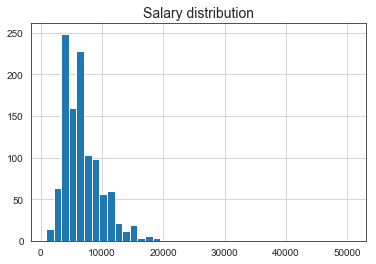

In [25]:
# take a look of the distribution of the salary
q1_jobs.job_salaries_mean.hist(bins=40)
plt.title('Salary distribution', size=14)

In [26]:
# setting the salary category

# take the mean and std of the salary
salary_mean = q1_jobs.job_salaries_mean.median()
salary_mean_std = q1_jobs.job_salaries_mean.std()

# set the boundary of each job category
middle_salary = [(salary_mean - salary_mean_std/2), (salary_mean + salary_mean_std/2)]

In [27]:
# 3 salary categories, low, mid, high boundary as below
middle_salary

[4300.015609448624, 7699.984390551376]

In [28]:
# initial salary category
q1_jobs['salary_cate'] = np.nan

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# define function to set the salary category
def salary_to_cate(x, middle_salary = middle_salary ):
    if x<middle_salary[0]:
        return 0
    elif x<middle_salary[1]:
        return 1
    else:
        return 2

In [30]:
# assign salary category
q1_jobs.salary_cate = q1_jobs.job_salaries_mean.map(salary_to_cate)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [31]:
# take a look at the number of jobs in each category, low 267, mid 510, high 322
q1_jobs.salary_cate.value_counts()

1    510
2    322
0    267
Name: salary_cate, dtype: int64

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [32]:
# take a look of all features
q1_jobs.columns

Index(['company_name', 'job_categories', 'job_experience', 'job_level',
       'job_link', 'job_location', 'job_requirement', 'job_role_resp',
       'job_salaries_max', 'job_salaries_min', 'job_salaries_type',
       'job_skills', 'job_title', 'job_type', 'job_salaries_mean',
       'job_salaries_range', 'job_label', 'salary_cate'],
      dtype='object')

In [33]:
# check the number of missing data point for each feature
q1_jobs.isnull().sum()

company_name             0
job_categories           0
job_experience        1033
job_level                0
job_link                 0
job_location           198
job_requirement         39
job_role_resp            0
job_salaries_max         0
job_salaries_min         0
job_salaries_type        0
job_skills               0
job_title                0
job_type                 0
job_salaries_mean        0
job_salaries_range       0
job_label                0
salary_cate              0
dtype: int64

## The choosen features are: 
1. job_categories: which industry
2. job_level: freash, manager etc
3. job_skills: whats the required skills
4. job_label: what is the job, data scientist, data entry etc
5. job_type: contract, full time, permenent, part-time etc

In [34]:
# take a look of the salary distribution vs job label
# the min, max, mean salary follow the same trend
# the range of the salary (max - min) get wider when the salary increased
# the job title shall related to the job label, however the need other features to explain the range change
q1_jobs.groupby(['job_label']).mean().sort_values(by='job_salaries_max')

,job_salaries_max,job_salaries_min,job_salaries_mean,job_salaries_range,salary_cate
job_label,,,,,
entry,2021.428571,1500.000000,1760.714286,521.428571,0.000000
Research,6653.735876,3886.539548,5270.137712,2767.196328,0.622881
data_engineer,8346.158263,5210.840336,6778.499300,3135.317927,1.033613
data_analyst,8381.728395,5288.135802,6834.932099,3093.592593,1.086420
other_analyst,8396.829861,5359.280093,6878.054977,3037.549769,1.090278
data_scientist,9782.408964,6132.997199,7957.703081,3649.411765,1.369748
solution_architect,11122.178862,6872.894309,8997.536585,4249.284553,1.593496


In [35]:
# since the job post may have multiple job level selected, will need to separate the job levels in the same job post.
# we will use a special tokenizer for other multi-selected feature
class MyTokenizer(object):
    def __call__(self,s):
        return  [WordNetLemmatizer().lemmatize(ele.strip()) for ele in s.split(',')]


In [36]:
# job_level count vectorize to get the job levels
job_level_countVect = CountVectorizer(tokenizer=MyTokenizer(), analyzer='word', binary=True)
job_level_df= pd.DataFrame(job_level_countVect.fit_transform(q1_jobs.job_level).todense(),columns=job_level_countVect.get_feature_names() )


In [37]:
# Since we are going to use Salary mean as the target,
# if a job post has multiple job level selected, we are going to choose the mean level as the job level for this post

# convert the job level to numbers, which follow the general career progression
job_level_dict =dict( zip(job_level_countVect.get_feature_names(),[3,0,2,6,7,1,5,4,8]))
job_level_dict

{'executive': 3,
 'fresh/entry level': 0,
 'junior executive': 2,
 'manager': 6,
 'middle management': 7,
 'non-executive': 1,
 'professional': 5,
 'senior executive': 4,
 'senior management': 8}

In [38]:
# separate the job multiple job level and select the mean level
job_level_digit = q1_jobs.job_level.map(lambda x: \
                                        np.ceil(np.mean([job_level_dict[ele.strip().lower()] \
                                                       for ele in x.split(',') if ele.strip!=''])))

# get dummies and take fresh(0) as reference
job_level_df = pd.get_dummies(job_level_digit)
job_level_df = job_level_df.drop(columns=[0])
job_level_df.reset_index(drop=True, inplace=True)
job_level_df.shape

(1099, 8)

In [39]:
# tfidf the job_categories
# since one job can be multiple industry related, we are going to allowed multiple job categories for each post
job_cate_countVect = TfidfVectorizer(tokenizer=MyTokenizer(), analyzer='word')
job_cate_df= pd.DataFrame(job_cate_countVect.fit_transform(q1_jobs.job_categories).todense(),columns=job_cate_countVect.get_feature_names() )
job_cate_df.shape

(1099, 32)

In [40]:
# same for the job skill
job_skill_countVect = TfidfVectorizer(tokenizer=MyTokenizer(),  analyzer='word')
job_skill_df= pd.DataFrame(job_skill_countVect.fit_transform(q1_jobs.job_skills).todense(),columns=job_skill_countVect.get_feature_names() )
job_skill_df.shape

(1099, 761)

In [41]:
# job_type just to check which job type the job post have
job_type_countVect = CountVectorizer(tokenizer=MyTokenizer(), analyzer='word', binary=True)
job_type_df= pd.DataFrame(job_type_countVect.fit_transform(q1_jobs.job_type).todense(),columns=job_type_countVect.get_feature_names() )
job_type_df.shape

(1099, 8)

In [42]:
# job_label, one hot code the feature, take data entry job as reference 
job_label_df = pd.get_dummies(q1_jobs.job_label)
job_label_df = job_label_df.drop(columns=['entry'])
job_label_df.reset_index(drop=True, inplace=True)
job_label_df.shape

(1099, 6)

In [43]:
# concate all featuers
X = pd.concat([job_level_df, job_cate_df, job_skill_df,job_type_df, job_label_df], axis=1)
X.shape

(1099, 815)

In [44]:
# take job salary_cate as target
y = q1_jobs.salary_cate

In [45]:
# train test splite
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

In [46]:
# model 1 logistic regression with standardized features
# multiple class, will take the classifcation report as matrix

logR = LogisticRegressionCV(class_weight='balanced', penalty='l2', max_iter=5000 , cv=5, scoring='f1_micro')
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
logR.fit(X_train_ss, y_train)
X_test_ss = scaler.transform(X_test)
y_pred = logR.predict(X_test_ss)
print(classification_report(y_test, y_pred))

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.71      0.73        89
           1       0.58      0.67      0.62       160
           2       0.55      0.46      0.50       114

   micro avg       0.61      0.61      0.61       363
   macro avg       0.63      0.61      0.62       363
weighted avg       0.62      0.61      0.61       363



C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [47]:
# model 2 Multinomail Naive bayern 

MNB = MultinomialNB()
print(cross_val_score(MNB, X_train, y_train, cv=10, scoring='f1_micro'))

MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)
print(classification_report(y_test, y_pred))

[ 0.60810811  0.59459459  0.62162162  0.67567568  0.62162162  0.56756757
  0.68918919  0.72972973  0.58333333  0.47222222]
              precision    recall  f1-score   support

           0       0.84      0.55      0.67        89
           1       0.55      0.78      0.64       160
           2       0.65      0.45      0.53       114

   micro avg       0.62      0.62      0.62       363
   macro avg       0.68      0.59      0.61       363
weighted avg       0.65      0.62      0.61       363



In [48]:
# model 3 RandomForestClassifier with SMOTE oversampling
# imb_pipleine = imPipeline([('smt', SMOTE()), ('estimator',RandomForestClassifier())])
# parameter = {
#     'smt__k_neighbors': range(3, 9),
#     'smt__sampling_strategy': ['minority'],
#     'estimator__class_weight':[{0:1,1:1, 2:1}, {0:1,1:1.5, 2:1.5}, {0:1,1:2, 2:2}, {0:1,1:3, 2:3}, {0:1,1:2, 2:3}, {0:1,1:3, 2:2}],
#     'estimator__n_estimators': [ 15, 20, 30, 40, 50, 100],
#     'estimator__max_depth': [10, 15, 30, 40, 60, 100],
#     'estimator__min_samples_split': [20, 10, 6, 4, 2]
# }

# imb_pipleine_gs = GridSearchCV(imb_pipleine, parameter,scoring='f1_micro' ,cv=5, verbose=1, n_jobs=4)
# imb_pipleine_gs.fit(X_train, y_train)
# y_pred = imb_pipleine_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [49]:
# with open('3class_randomF_12.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs, f)

In [50]:
with open('3class_randomF_12.p', 'rb') as f:
    imb_pipleine_rf_gs = pickle.load(f)

In [51]:
y_pred = imb_pipleine_rf_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.55      0.69        89
           1       0.55      0.91      0.69       160
           2       0.70      0.27      0.39       114

   micro avg       0.62      0.62      0.62       363
   macro avg       0.73      0.58      0.59       363
weighted avg       0.69      0.62      0.59       363



In [52]:
# # model 4 RandomForestClassifier with balanced weight
# rf = RandomForestClassifier(class_weight='balanced')
# rf_parameter = {'n_estimators': [10, 15, 20, 50,100, 200, 300],
#                 'max_depth': [10, 15, 30, 60, 100, 200, 400],
#                 'min_samples_split': [20, 10, 6, 4, 2]
  
# }

# rf_gs = GridSearchCV(rf, rf_parameter,scoring='f1_micro' ,cv=5, n_jobs=4, verbose=1)
# rf_gs.fit(X_train, y_train)
# y_pred = rf_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [53]:
# with open('3class_rf_weight_12.p', 'wb') as f:
#     pickle.dump(rf_gs, f)

In [54]:
with open('3class_rf_weight_12.p', 'rb') as f:
    rf_gs = pickle.load(f)

In [55]:
y_pred = rf_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.69      0.73        89
           1       0.59      0.77      0.67       160
           2       0.61      0.42      0.50       114

   micro avg       0.64      0.64      0.64       363
   macro avg       0.66      0.63      0.63       363
weighted avg       0.65      0.64      0.63       363



In [56]:
# # model 5 GradientBoostingClassifier with balanced weight

# imb_pipleine = imPipeline([('smt', SMOTE()), ('estimator',GradientBoostingClassifier())])

# parameter = {
#     'estimator__learning_rate': [0.1, 0.5, 1],
#     'estimator__max_depth': [20, 50, 70],
#     'estimator__max_features': ['auto', 'log2', 0.4],
#     'estimator__max_leaf_nodes': [3, 5, 10 ],
#     'estimator__min_samples_leaf': [1,3, 5],
#     'estimator__min_samples_split': [2, 4, 6],
#     'estimator__n_estimators': [ 10, 50, 100]
# }

# imb_pipleine_gs = GridSearchCV(imb_pipleine, parameter,scoring='f1_micro' ,cv=5, n_jobs=4, verbose=1)
# imb_pipleine_gs.fit(X_train, y_train)
# y_pred = imb_pipleine_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [57]:
# with open('3class_xgb_12.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs, f)

In [58]:
with open('3class_xgb_12.p', 'rb') as f:
    imb_pipleine_xgb_gs = pickle.load(f)

In [59]:
y_pred = imb_pipleine_xgb_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        89
           1       0.62      0.71      0.66       160
           2       0.63      0.53      0.57       114

   micro avg       0.67      0.67      0.67       363
   macro avg       0.69      0.67      0.68       363
weighted avg       0.67      0.67      0.67       363



# Choose the model 5
1. The model 1 give good score on the classification

              precision    recall  f1-score   support

               0       0.82      0.78      0.80        89
               1       0.62      0.71      0.66       160
               2       0.63      0.53      0.57       114

       micro avg       0.67      0.67      0.67       363
       macro avg       0.69      0.67      0.68       363
       weighted avg    0.67      0.67      0.67       363
       
2. The most important factors are:
    - job_level: level 2 'junior executive', 3 'executive', 6 'manager', this experience few unusual findings a. frame job level 2 (junior executive) to job level 1 (non-executive) there is a drop in the job level, maybe some non-executive people have more salary than junior executive, again compair to level 3 'executive', there is a jump. job level 6 manager has higher pay then middle management, which is unusual to the career level salary curve
    - job_skill: The following skills give impact on the salary 
    python, risk management, cross-functional team leadership, artificial intelligence, public speaking, integration, business development,	business intelligence, web development engineering, algorithm, digital marketing(See below dataframe)
    - job_category: information technology,	banking and finance, others. This three job industries give impact in the salary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029D571DA588>]], dtype=object)

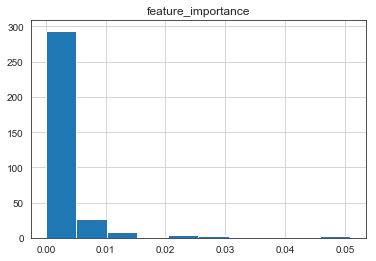

In [60]:
# create pd for the importance feactors with coresponding feature name and category
xgboost_feature_improtances = pd.DataFrame(imb_pipleine_xgb_gs.best_estimator_.named_steps['estimator'].feature_importances_, index=X.columns, columns=['feature_importance'])

# get list of feature types
feature_type = []
for i, feature in enumerate([job_level_df, job_cate_df, job_skill_df,job_type_df, job_label_df]):
    feature_type.extend([i for _ in feature.nunique()])

# adding feature type in feature importance figure     
xgboost_feature_improtances.insert(loc=1, value=feature_type, column='feature_type')
xgboost_feature_improtances.feature_type = xgboost_feature_improtances.feature_type.map({0:'job_level_df', 1:'job_cate_df', 2:'job_skill_df', 3:'job_type_df', 4:'job_label_df'})

# get feature importance distribution
xgboost_feature_improtances[xgboost_feature_improtances.feature_importance>0].hist()

In [61]:
xgboost_feature_improtances.feature_importance.describe()

count    815.000000
mean       0.001227
std        0.004193
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000630
max        0.050934
Name: feature_importance, dtype: float64

In [62]:
# choose the features above 0.01 for analysis
xgboost_feature_improtances.loc[xgboost_feature_improtances.feature_importance>0.01].\
    sort_values(by='feature_importance', ascending=False)

,feature_importance,feature_type
2.0,0.050934,job_level_df
python,0.048661,job_skill_df
risk management,0.041965,job_skill_df
3.0,0.030830,job_level_df
6.0,0.026784,job_level_df
cross-functional team leadership,0.026437,job_skill_df
artificial intelligence,0.026322,job_skill_df
information technology,0.024200,job_cate_df
solution_architect,0.021286,job_label_df
public speaking,0.021247,job_skill_df


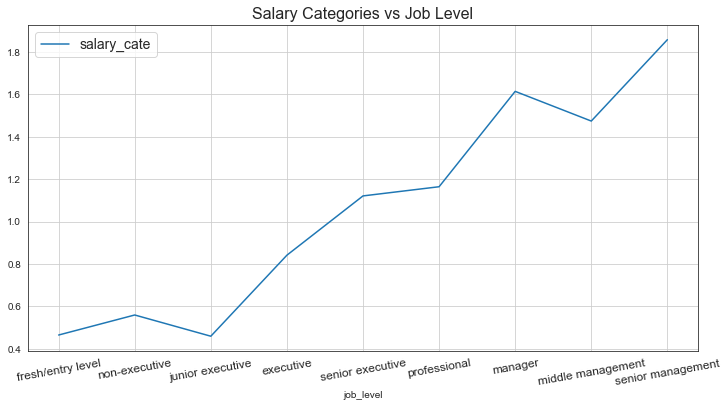

In [63]:
# plot the salary categories vs job level
pd.concat([job_level_digit, y], axis=1).groupby(['job_level']).mean().plot()
plt.gcf().set_size_inches(12,6)
plt.grid()
plt.xticks(range(9), ['fresh/entry level', 'non-executive', 'junior executive', 'executive', \
            'senior executive', 'professional', 'manager', 'middle management', 'senior management'], size=12, rotation=10)
plt.title('Salary Categories vs Job Level', size=16)
plt.legend( prop={'size': 14})

In [64]:
# display the feature importance for skills
xgboost_feature_improtances.loc[ (xgboost_feature_improtances.feature_type=='job_skill_df') & (xgboost_feature_improtances.feature_importance>0.01), :].sort_values(by='feature_importance', ascending=False)

,feature_importance,feature_type
python,0.048661,job_skill_df
risk management,0.041965,job_skill_df
cross-functional team leadership,0.026437,job_skill_df
artificial intelligence,0.026322,job_skill_df
public speaking,0.021247,job_skill_df
integration,0.020422,job_skill_df
business development,0.014264,job_skill_df
business intelligence,0.012738,job_skill_df
web development,0.012383,job_skill_df
engineering,0.011816,job_skill_df


## Question 2
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


# Question 2 problem

Determine what is the factors distinguish industrial oriented analyst( other_analyst ) from skill oriented postion (the rest of job labels)

In [65]:
# take a look of job labels
q1_jobs.job_label.value_counts()

other_analyst         288
data_engineer         238
Research              236
solution_architect    123
data_scientist        119
data_analyst           81
entry                  14
Name: job_label, dtype: int64

In [66]:
# generate predictor for q2, taking job_level, job_cate, job_skill, job_type
X_q2 = pd.concat([job_level_df, job_cate_df, job_skill_df,job_type_df ], axis=1)

# target 1 for other_analyst, 0 for the rest
y_q2 = (q1_jobs.job_label=='other_analyst').map({False:0, True:1})

# train test split
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2, y_q2, test_size=0.33, random_state=13)
X_train_q2.shape, X_test_q2.shape, y_train_q2.shape

((736, 809), (363, 809), (736,))

In [69]:
# model 1 logistic regression with standardized features

logR_q2 = LogisticRegressionCV(class_weight='balanced', penalty='l2', max_iter=5000 , cv=5, scoring='f1_micro')
scaler_q2 = StandardScaler()
X_train_ss_q2 = scaler_q2.fit_transform(X_train_q2)
logR_q2.fit(X_train_ss_q2, y_train_q2)
X_test_ss_q2 = scaler_q2.transform(X_test_q2)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [70]:
y_pred_q2= logR_q2.predict(X_test_ss_q2)
print(classification_report(y_test_q2, y_pred_q2))
y_pred_proba = logR_q2.predict_proba(X_test_ss_q2)
fpr, tpr, _ = roc_curve(y_test_q2, y_pred_proba[:,1])
print(f"AUC {auc(fpr,tpr)}")
pd.DataFrame(confusion_matrix(y_pred_q2, y_test_q2), columns=['not_other_analyst_classified', 'other_analyst_classified'], index=['not_other_analyst_real', 'other_analyst_real'])


              precision    recall  f1-score   support

           0       0.91      0.84      0.88       272
           1       0.62      0.76      0.68        91

   micro avg       0.82      0.82      0.82       363
   macro avg       0.76      0.80      0.78       363
weighted avg       0.84      0.82      0.83       363

AUC 0.885989010989011


,not_other_analyst_classified,other_analyst_classified
not_other_analyst_real,229,22
other_analyst_real,43,69


In [71]:
# model 2 Multinomail Naive bayern 

MNB_q2 = MultinomialNB()
print(cross_val_score(MNB_q2, X_train_q2, y_train_q2, cv=10, scoring='f1_micro'))
MNB_q2.fit(X_train_q2, y_train_q2)


[ 0.82432432  0.85135135  0.75675676  0.90540541  0.77027027  0.81081081
  0.81081081  0.84931507  0.8630137   0.83333333]


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [72]:
y_pred_q2= MNB_q2.predict(X_test_ss_q2)
print(classification_report(y_test_q2, y_pred_q2))
y_pred_proba = MNB_q2.predict_proba(X_test_ss_q2)
fpr, tpr, _ = roc_curve(y_test_q2, y_pred_proba[:,1])
print(f"AUC {auc(fpr,tpr)}")
pd.DataFrame(confusion_matrix(y_pred_q2, y_test_q2), columns=['not_other_analyst_classified', 'other_analyst_classified'], index=['not_other_analyst_real', 'other_analyst_real'])


              precision    recall  f1-score   support

           0       0.97      0.67      0.79       272
           1       0.49      0.93      0.64        91

   micro avg       0.74      0.74      0.74       363
   macro avg       0.73      0.80      0.72       363
weighted avg       0.85      0.74      0.76       363

AUC 0.8771816418875243


,not_other_analyst_classified,other_analyst_classified
not_other_analyst_real,183,6
other_analyst_real,89,85


In [75]:
# model 3 RandomForestClassifier with SMOTE oversampling
# imb_pipleine_q2 = imPipeline([('smt', SMOTE()), ('estimator',RandomForestClassifier())])
# parameter_q2 = {
#     'smt__k_neighbors': range(3, 9),
#     'smt__sampling_strategy': ['minority'],
# #     'estimator__class_weight':[{0:1,1:1}, {0:1,1:1.5}, {0:1,1:2}, {0:1,1:3}, {0:1,1:2}, {0:1,1:3},{0:1,1:4}],
#     'estimator__class_weight':[  {0:1,1:2}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}],
#     'estimator__n_estimators': [ 15, 20, 30, 40, 50, 100],
#     'estimator__max_depth': [10, 15, 30, 40, 60, 100],
#     'estimator__min_samples_split': [20, 10, 6, 4, 2]
# }

# imb_pipleine_gs_q2 = GridSearchCV(imb_pipleine_q2, parameter_q2,scoring='f1_micro' ,cv=3, verbose=1, n_jobs=7)
# imb_pipleine_gs_q2.fit(X_train_q2, y_train_q2)


Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    8.2s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   17.2s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   29.1s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:   45.0s
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed:  4.4min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done 9786 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 11236 tasks      | elapsed:  7.0mi

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('smt', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
   ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=7,
       param_grid={'smt__k_neighbors': range(3, 9), 'smt__sampling_strategy': ['minority'], 'estimator__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 6}], 'estimator__n_estimators': [15, 20, 30, 40, 50, 100], 'estimator__max_depth': [10, 15, 30, 40, 60, 100], 'estimator__min_samples_split': [20, 10, 6, 4, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [77]:
# with open('q2_rf_imb_weight_13.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs_q2, f)

In [78]:
with open('q2_rf_imb_weight_13.p', 'rb') as f:
    imb_pipleine_rf_q2 = pickle.load(f)

In [79]:
y_pred_q2= imb_pipleine_rf_q2.predict(X_test_ss_q2)
print(classification_report(y_test_q2, y_pred_q2))
y_pred_proba = imb_pipleine_rf_q2.predict_proba(X_test_ss_q2)
fpr, tpr, _ = roc_curve(y_test_q2, y_pred_proba[:,1])
print(f"AUC {auc(fpr,tpr)}")
pd.DataFrame(confusion_matrix(y_pred_q2, y_test_q2), columns=['not_other_analyst_classified', 'other_analyst_classified'], index=['not_other_analyst_real', 'other_analyst_real'])


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       272
           1       0.69      0.66      0.67        91

   micro avg       0.84      0.84      0.84       363
   macro avg       0.79      0.78      0.78       363
weighted avg       0.84      0.84      0.84       363

AUC 0.8664148351648352


,not_other_analyst_classified,other_analyst_classified
not_other_analyst_real,245,31
other_analyst_real,27,60


In [80]:
# # # # model 4 RandomForestClassifier with balanced weight
# rf_q2 = RandomForestClassifier(class_weight='balanced')
# rf_parameter_q2 = {'n_estimators': [10, 15, 20, 50,100, 200, 300],
#                 'max_depth': [10, 15, 30, 60, 100, 200, 400],
#                 'min_samples_split': [20, 10, 6, 4, 2]
  
# }

# rf_gs_q2 = GridSearchCV(rf_q2, rf_parameter_q2,scoring='f1_micro',cv=5, n_jobs=4, verbose=1)
# rf_gs_q2.fit(X_train_q2, y_train_q2)


Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 564 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 1064 tasks      | elapsed:   58.0s
[Parallel(n_jobs=4)]: Done 1218 out of 1225 | elapsed:  1.1min remaining:    0.3s
[Parallel(n_jobs=4)]: Done 1225 out of 1225 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [10, 15, 20, 50, 100, 200, 300], 'max_depth': [10, 15, 30, 60, 100, 200, 400], 'min_samples_split': [20, 10, 6, 4, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [81]:
# with open('q2_rf_weight_13.p', 'wb') as f:
#     pickle.dump(rf_gs_q2, f)

In [82]:
with open('q2_rf_weight_13.p', 'rb') as f:
    rf_gs_q2 = pickle.load(f)

In [83]:
y_pred_q2= rf_gs_q2.predict(X_test_ss_q2)
print(classification_report(y_test_q2, y_pred_q2))
y_pred_proba = rf_gs_q2.predict_proba(X_test_ss_q2)
fpr, tpr, _ = roc_curve(y_test_q2, y_pred_proba[:,1])
print(f"AUC {auc(fpr,tpr)}")
pd.DataFrame(confusion_matrix(y_pred_q2, y_test_q2), columns=['not_other_analyst_classified', 'other_analyst_classified'], index=['not_other_analyst_real', 'other_analyst_real'])


              precision    recall  f1-score   support

           0       0.94      0.74      0.83       272
           1       0.53      0.87      0.66        91

   micro avg       0.77      0.77      0.77       363
   macro avg       0.74      0.81      0.74       363
weighted avg       0.84      0.77      0.79       363

AUC 0.8697882999353588


,not_other_analyst_classified,other_analyst_classified
not_other_analyst_real,202,12
other_analyst_real,70,79


In [ ]:
# # model 5 GradientBoostingClassifier with balanced weight

imb_pipleine_q2 = imPipeline([('smt', SMOTE()), ('estimator',GradientBoostingClassifier())])

parameter_q2 = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [20, 50, 70],
    'estimator__max_features': ['auto', 'log2', 0.4],
    'estimator__max_leaf_nodes': [3, 5, 10 ],
    'estimator__min_samples_leaf': [1,3, 5],
    'estimator__min_samples_split': [2, 4, 6],
    'estimator__n_estimators': [ 10, 50, 100]
}

imb_pipleine_gs_q2 = GridSearchCV(imb_pipleine_q2, parameter_q2,scoring='f1_micro' ,cv=5, n_jobs=7, verbose=1)
imb_pipleine_gs_q2.fit(X_train_q2, y_train_q2)
y_pred_q2 = imb_pipleine_gs_q2.predict(X_test_q2)
print(classification_report(y_test_q2, y_pred_q2))

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  5.8min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  8.9min


In [ ]:
with open('q2_xgb_13.p', 'wb') as f:
    pickle.dump(imb_pipleine_gs_q2, f)

In [ ]:
with open('q2_xgb_13.p', 'rb') as f:
    imb_pipleine_gs_q2 = pickle.load(f)

In [ ]:
y_pred_q2= imb_pipleine_gs_q2.predict(X_test_ss_q2)
print(classification_report(y_test_q2, y_pred_q2))
y_pred_proba = imb_pipleine_gs_q2.predict_proba(X_test_ss_q2)
fpr, tpr, _ = roc_curve(y_test_q2, y_pred_proba[:,1])
print(f"AUC {auc(fpr,tpr)}")
pd.DataFrame(confusion_matrix(y_pred_q2, y_test_q2), columns=['not_other_analyst_classified', 'other_analyst_classified'], index=['not_other_analyst_real', 'other_analyst_real'])


# Choose the model 1
1. The model 1 give good score on the classification

                   precision    recall  f1-score   support

               0       0.91      0.84      0.88       272
               1       0.62      0.76      0.68        91

       micro avg       0.82      0.82      0.82       363
       macro avg       0.76      0.80      0.78       363
       weighted avg    0.84      0.82      0.83       363
       
                                not_other_analyst_classified	other_analyst_classified
        not_other_analyst_real	            242	                          36
        other_analyst_real	                30	                           55
        
        AUC 0.8677480607627667
        
       
2. The top 20 positive factors are:
    - job_type: Full time
    - job_skill: web development, juniper, nonprofit, process improvement, forecasting, finance, requirements analysis, project management, customer satisfaction, olap, marketing communications, bloomberg, web applications
    - job_category: professional services, finance, healthcare / pharmaceutical, banking and finance, general management, consulting
    - job_level: 2 junior executive
    
32. The top 20 negative factors are:
    - job_category:  engineering, public / civil service, sales / retail, logistics / supply chain, advertising / media, general work
    - job_skill: research, marketing research, editing, solution architecture, web services, team management, database design, cloud computing, c	-0.120485, t-sql, start-ups, team leadership
    - job_level: 5.0 professional , 7.0 middle management

In [ ]:
# create pd for the feacture coefs with coresponding feature name and category
logR_coef = pd.DataFrame(logR_q2.coef_.T, index=X_q2.columns, columns=['feature_importance'])
feature_type = []
for i, feature in enumerate([job_level_df, job_cate_df, job_skill_df,job_type_df]):
    feature_type.extend([i for _ in feature.nunique()])
    
logR_coef.insert(loc=1, value=feature_type, column='feature_type')
logR_coef.feature_type = logR_coef.feature_type.map({0:'job_level_df', 1:'job_cate_df', 2:'job_skill_df', 3:'job_type_df'})

# get feature importance distribution
logR_coef[logR_coef.feature_importance.abs()>0].hist()

In [ ]:
logR_coef.iloc[np.argsort(logR_coef.feature_importance)[::-1]].head(20)

In [ ]:
logR_coef.iloc[np.argsort(logR_coef.feature_importance)].head(20)

# Bonus
Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [ ]:
# create scoring function. That predict a wrong higher salary will give 10 times loss than predict a wrong lower salary,
# $10000 vs $1000
def my_scorer(y_true, y_pred):
    error = 0
    for i, y in enumerate(y_true):
        if y_pred[i]< y:
            error += 1000
        elif y_pred[i]>y:
            error += 10000
    return error
my_scorer_scorer = make_scorer(my_scorer, greater_is_better=False)

In [ ]:
# # model 5 GradientBoostingClassifier with balanced weight

imb_pipleine_bonus = imPipeline([('smt', SMOTE()), ('estimator',GradientBoostingClassifier())])

parameter_bonus = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': [20, 50, 70],
    'estimator__max_features': ['auto', 'log2', 0.4],
    'estimator__max_leaf_nodes': [3, 5, 10 ],
    'estimator__min_samples_leaf': [1,3, 5],
    'estimator__min_samples_split': [2, 4, 6],
    'estimator__n_estimators': [ 10, 50, 100]
}

imb_pipleine_gs_bonus = GridSearchCV(imb_pipleine_bonus, parameter_bonus,scoring=my_scorer_scorer ,cv=5, n_jobs=7, verbose=1)
imb_pipleine_gs_bonus.fit(X_train, y_train)
y_pred = imb_pipleine_gs_bonus.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# with open('bonus.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs_bonus, f)

In [ ]:
with open('bonus.p', 'rb') as f:
    imb_pipleine_gs_bonus = pickle.load(f)

In [ ]:
y_pred = imb_pipleine_gs_bonus.predict(X_test)
print(classification_report(y_test, y_pred))